# Quenching and drifting examples
In this notebook we apply the quenching and drifting stages to a track dataset

In [ ]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [ ]:
from larndsim import detsim

import importlib
importlib.reload(detsim)
from larndsim import consts, quenching, drifting
importlib.reload(drifting)
importlib.reload(quenching)

import matplotlib.pyplot as plt

import pickle
import numpy as np
import numba as nb

from tqdm import tqdm_notebook as progress_bar

In [3]:
tracks = pickle.load(open('FakeTrackDataSet.p', 'rb'))
tracks['t'] = 0.
tracks['t_start'] = 0.
tracks['t_end'] = 0.

tracks['dx'] = np.sqrt(pow(tracks['x_end']-tracks['x_start'], 2) +
                    pow(tracks['y_end']-tracks['y_start'], 2) +
                    pow(tracks['z_end']-tracks['z_start'], 2))
tracks['x'] = (tracks['x_end']+tracks['x_start'])/2
tracks['y'] = (tracks['y_end']+tracks['y_start'])/2
tracks['z'] = (tracks['z_end']+tracks['z_start'])/2
tracks['dE'] = np.abs(tracks['dE'])*1e3
tracks['dEdx'] = tracks['dE']/tracks['dx']
tracks['NElectrons'] = 0.
tracks['longDiff'] = 0.
tracks['tranDiff'] = 0.

In [4]:
tracks_np = tracks.to_numpy()
cols = nb.typed.Dict()
for i, c, in enumerate(tracks.columns):
    cols[c] = i

In [5]:
tracks_box = np.copy(tracks_np)
tracks_birks = np.copy(tracks_np)

In [6]:
quenching.Quench(tracks_box, cols, mode="box")
quenching.Quench(tracks_birks, cols, mode="birks")

## Recombination

The number of ionized electrons must be corrected by the recombination effect. Two models have been implemented:

- Birks (Amoruso et al. NIM A 523 (2004) 275)
\begin{equation}
R_{Birks} = \frac{A_b}{1+k_b/\epsilon\cdot dE/dx }
\end{equation}

- Modified box (Baller, 2013 JINST 8 P08005)
\begin{equation}
R_{box} = \frac{\log(\alpha + \beta \frac{dE/dx}{E\rho})}{\beta/\epsilon\cdot dE/dx}
\end{equation}

where $\epsilon=E\rho_{\mathrm{LAr}}$.

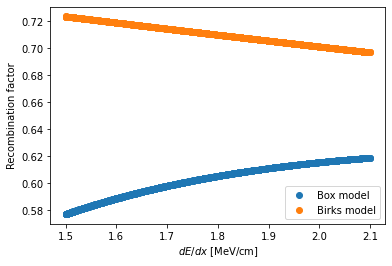

In [7]:
fig, ax = plt.subplots(1, 1)

recomb_birks = tracks_birks[:,cols['NElectrons']] / (consts.MeVToElectrons * tracks_birks[:,cols['dE']])
recomb_box = tracks_box[:,cols['NElectrons']] / (consts.MeVToElectrons * tracks_box[:,cols['dE']])

ax.scatter(tracks_box[:,cols['dEdx']], recomb_box, label="Box model")
ax.scatter(tracks_birks[:,cols['dEdx']], recomb_birks, label="Birks model")
ax.set_xlabel("$dE/dx$ [MeV/cm]")
ax.set_ylabel("Recombination factor")
_ = ax.legend()

In [8]:
quenching.Quench(tracks_np, cols)
tracks_quenched = np.copy(tracks_np)
drifting.Drift(tracks_np, cols)
tracks_drifted = np.copy(tracks_np)

## Electron lifetime
The electrons traveling towards the anode are absorbed by impurities present in the liquid argon. The decrease follows an exponential curve $N_e^{\mathrm{anode}}/N_e=\exp(-t_{\mathrm{drift}}/e_{\mathrm{lifetime}})$.

Text(0.5, 0, '$z$ coordinate [cm]')

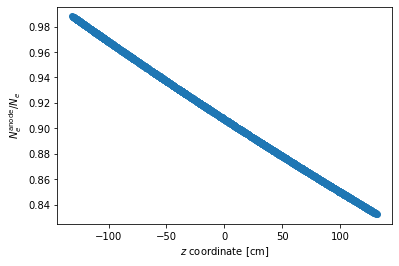

In [9]:
fig, ax = plt.subplots(1, 1)
ax.scatter(tracks_quenched[:,cols["z"]], tracks_drifted[:,cols["NElectrons"]]/tracks_quenched[:,cols["NElectrons"]])
ax.set_ylabel("$N_{e}^{\mathrm{anode}}/N_{e}$")
ax.set_xlabel("$z$ coordinate [cm]")

## Diffusion
The diffusion coefficients (longitudinal and transverse) are proportional to $\sqrt{t_{\mathrm{drift}}}$ (which in turn is given by $(z_{\mathrm{start}} - z_{\mathrm{anode}})/v_{\mathrm{drift}}$).

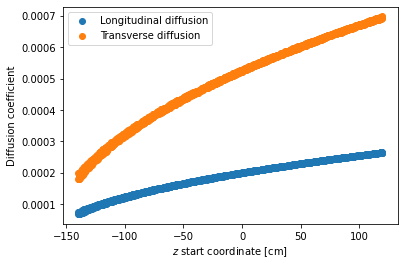

In [10]:
fig, ax = plt.subplots(1, 1)
ax.scatter(tracks_np[:,cols["z_start"]], tracks_np[:,cols["longDiff"]], label="Longitudinal diffusion")
ax.scatter(tracks_np[:,cols["z_start"]], tracks_np[:,cols["tranDiff"]], label="Transverse diffusion")
ax.set_xlabel("$z$ start coordinate [cm]")
ax.set_ylabel("Diffusion coefficient")
_ = ax.legend()